In [1]:
import numpy as np
import xarray as xr
import dask
import intake
import pandas as pd
import os
from collections import defaultdict
from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!
from xmip.utils import google_cmip_col
from xmip.postprocessing import combine_datasets, _match_datasets,_concat_sorted_time

/tmp/ipykernel_2983/3160798905.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!


In [2]:
def preselect_years(ddict_in,start_year,end_year):
    '''select range of years of datasets'''
    ddict_out = defaultdict(dict)
    
    assert start_year<end_year
        
    if start_year>2014: #only using SSP
        for k, v in ddict_in.items():
            if 'ssp' in k:
                ddict_out[k] = v.sel(time=slice(str(start_year), str(end_year)))
                
    elif end_year<=2014: #only using historical
        for k, v in ddict_in.items():
            if 'historical' in k:
                ddict_out[k] = v.sel(time=slice(str(start_year), str(end_year)))
                
    elif ((start_year<=2014) & (end_year>2014)): #using both
        for k, v in ddict_in.items():
            if 'ssp' in k:
                ddict_out[k] = v.sel(time=slice(None, str(end_year)))
            elif 'historical' in k:
                ddict_out[k] = v.sel(time=slice(str(start_year), None))
    return ddict_out #NB: may result in no timesteps being selected at all

In [3]:
def pr_units_to_m(ddict_in):
    ddict_out = ddict_in
    for k, v in ddict_in.items():
        assert v.pr.units == 'kg m-2 s-1'
        
        with xr.set_options(keep_attrs=True): #convert 'kg m-2 s-1' to daily accumulated 'm'
            v['pr'] = 24*3600*v['pr']/1000 #multiply by number of seconds in a day to get to kg m-2, and divide by density (kg/m3) to get to m    
        v.pr.attrs['units'] = 'm'
        
        ddict_out[k] = v
    return ddict_out

In [4]:
model = 'MRI-ESM2-0'
variant = 'r1i1p1f1'
experiment = 'ssp585'

col = google_cmip_col()

cat_data = col.search( #find instances providing all required variables for both historical & ssp245
    source_id=model,
    experiment_id=experiment,
    table_id='day',
    variable_id='pr',
    member_id=variant,
    require_all_on=['source_id', 'member_id','grid_label']
)

cat_data.esmcat.aggregation_control.groupby_attrs = [] #to circumvent aggregate=false bug

kwargs = {
    'zarr_kwargs':{
        'consolidated':True,
        'use_cftime':True
    },
    'aggregate':True #to avoid this issue: https://github.com/intake/intake-esm/issues/496
    #doesn't actually aggregate if we set cmip6_cat.esmcat.aggregation_control.groupby_attrs = []
}

ddict = cat_data.to_dataset_dict(**kwargs) #open datasets into dictionary


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


/tmp/ipykernel_2983/462558404.py:27: DeprecationWarning: cdf_kwargs and zarr_kwargs are deprecated and will be removed in a future version. Please use xarray_open_kwargs instead.
  ddict = cat_data.to_dataset_dict(**kwargs) #open datasets into dictionary


In [5]:
ddict = preselect_years(ddict,2060,2080)
ddict = pr_units_to_m(ddict)

for key,ds in ddict.items():
    lon_coord = list(k for k in ds.dims if 'lon' in k)[0] #find lon/lat coordinate names
    
    ##!!! need to check this is only applied to models actually ranging from 0 to 360
    
    ds.coords[lon_coord] = ((ds.coords[lon_coord] + 180) % 360) - 180 #wrap around 0
    ds = ds.reindex({ lon_coord : np.sort(ds[lon_coord])})
    ddict[key] = ds


In [6]:
in_dir = '/home/jovyan/CMIP6cf/output/pr_timeseries/'

tg_pr = xr.open_mfdataset(os.path.join(in_dir,model,'*'+experiment+'*.nc'))

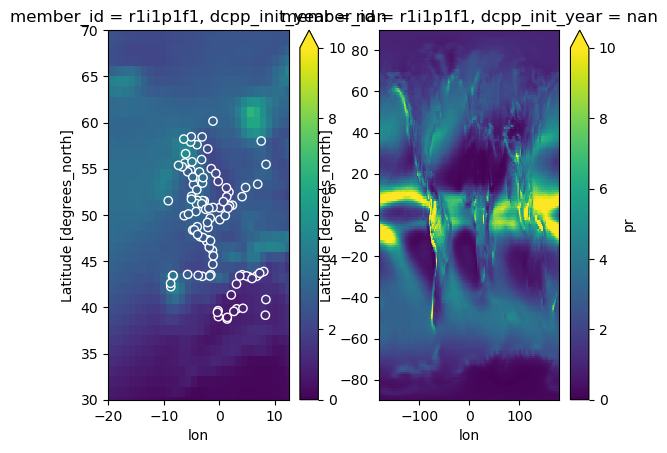

In [8]:
import matplotlib.pyplot as plt
plt.figure()
ax = plt.subplot(121)
(1000*ddict[list(ddict.keys())[0]].isel(member_id=0,dcpp_init_year=0).pr.mean(dim='time')).plot(vmin=0,vmax=10,ax=ax) #mm/day
ax.scatter(tg_pr.lon,tg_pr.lat,c=1000*tg_pr.sel(time=slice('2060','2080'),member_id=variant).mean(dim='time').pr,vmin=0,vmax=10,edgecolor='white')
ax.set_xlim([-20,12.5])
ax.set_ylim([30,70])

ax = plt.subplot(122)
(1000*ddict[list(ddict.keys())[0]].isel(member_id=0,dcpp_init_year=0).pr.mean(dim='time')).plot(vmin=0,vmax=10,ax=ax) #mm/day
#

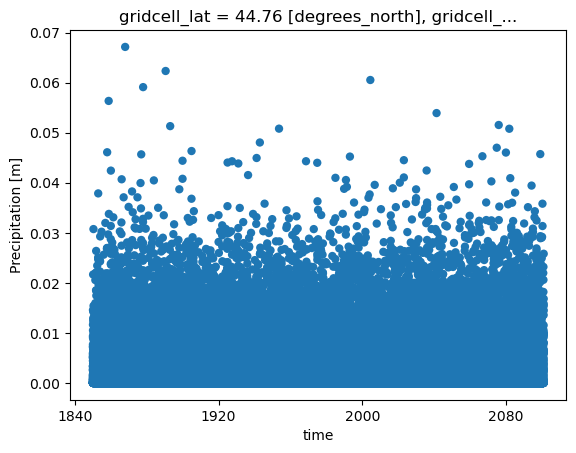

In [15]:
tg_pr.isel(tg=0,member_id=0).pr.plot.scatter(edgecolor='None')
